In [1]:
import jax
import jax.numpy as jnp
import inspeqtor as sq
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scienceplots

In [2]:
# Create path to save data
path = Path("./data_2/shots_ideal_test/")
path.mkdir(parents=True, exist_ok=True)
shots_list = [100, 1000, 10_000, 100_000]
# shots_list = [100]

## Generate ideal data with shot-estimated expectation values


In [ ]:
sample_size = 1500
key = jax.random.key(0)

for shots in shots_list:

    data_key, key = jax.random.split(key)

    # Generate mock data
    (
        exp_data,
        pulse_sequence,
        noisy_unitaries,
        signal_parameters_list,
        noisy_simulator,
    ) = sq.utils.helper.generate_mock_experiment_data(
        key=data_key,
        sample_size=sample_size,
        strategy=sq.utils.helper.SimulationStrategy.SHOT,
        shots=shots,
        get_pulse_sequence_fn=sq.utils.predefined.get_multi_drag_pulse_sequence_v3,
    )

    # Define the path to save the data
    data_path = path / str(exp_data.experiment_config.shots)

    # Save the data and pulse sequence
    exp_data.save_to_folder(data_path)
    pulse_sequence.to_file(data_path)

## Load data and train the model


In [ ]:
for shots in shots_list:

    data_path = path / str(shots)
    loaded_data = sq.utils.helper.load_data_from_path(data_path)
    key, model_key, train_key = jax.random.split(key, 3)

     # NOTE: flatten the pulse_parameters
    pulse_parameters = loaded_data.pulse_parameters.reshape(
        loaded_data.experiment_data.experiment_config.sample_size, -1
    )


    trainable = sq.optimizer.default_trainable_v2(
        pulse_sequence=loaded_data.pulse_sequence, loss_fn=sq.model_v2.MSEE_loss_fn
    )

    results = sq.optimizer.hypertuner(
        trainable=trainable,
        pulse_parameters=jnp.array(pulse_parameters),
        unitaries=jnp.array(loaded_data.unitaries),
        expectations=jnp.array(loaded_data.expectation_values),
        model_key=model_key,
        train_key=train_key,
        num_samples=1,
        search_algo=sq.optimizer.SearchAlgo.OPTUNA,
        metric="test/MSEE",
    )

    model_state, history, _ = sq.optimizer.get_best_hypertuner_results(results)

    # Save the model state
    sq.model.save_model(
        path=str(data_path / "model"),
        experiment_identifier=str(exp_data.experiment_config.shots),
        pulse_sequence=loaded_data.pulse_sequence,
        hamiltonian=sq.utils.helper.rotating_transmon_hamiltonian,
        model_config=model_state.model_config,
        model_params=model_state.model_params,
        history=history,
        with_auto_datetime=False,
    )

In [5]:
histories = {}
for shots in shots_list:

    data_path = path / str(shots)
    model_path = data_path / "model"
    model_state, history, data_config = sq.model.load_model(str(model_path))
    histories[shots] = history

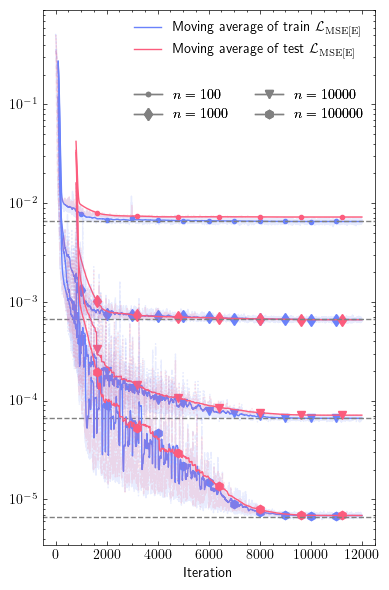

In [7]:
with plt.style.context("science"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))

    linestyles = ["solid", "dashed", "dotted", "dashdot"]
    # linestyles = ["solid", "dashed", "dotted", 'dashdot']
    markers = [".", "d", "v", "h"]

    for shots_idx, shots in enumerate(shots_list):

        history_df = pd.DataFrame(histories[shots])
        min_step, max_step = history_df["step"].min(), history_df["step"].max()
        loops = [("train", "#6a82fb"), ("test", "#fc5c7d")]
        for loop in loops:
            df = history_df[history_df["loop"] == loop[0]]
            y = df["MSEE"]
            x = df["step"]
            y_ma = df["MSEE"].rolling(100).mean().values

            latex_text = r"$\mathcal{L}_{\mathrm{MSE[E]}}$"
            ax.plot(x, y, alpha=0.15, color=loop[1], linestyle=linestyles[shots_idx])
            ax.plot(
                x,
                y_ma,
                color=loop[1],
                # label=(
                #     f"Moving average of {loop[0]} {latex_text}"
                #     if shots == 100
                #     else None
                # ),
                # linestyle=linestyles[shots_idx],
                marker=markers[shots_idx],
                markevery=1000 if loop[0] == "train" else 200,
            )

            if loop[0] == "test":
                # MAEF
                # y = df["MAEF"].values
                # y_ma = df["MAEF"].rolling(100).mean().values
                # # Convert the unit of MAEF to match MSEE
                # ax.plot(x, (4 / 3) * jnp.square(y), color="#a6e22e", alpha=0.15)
                # ax.plot(
                #     x,
                #     (4 / 3) * jnp.square(y_ma),
                #     color="#a6e22e",
                #     marker=markers[shots_idx],
                #     markevery=200,
                # )
                pass

        ax.set_yscale("log")
        y_value = 2 / (3 * shots)
        ax.hlines(
            y=y_value,
            xmin=min_step - 2000,
            xmax=max_step + 2000,
            linestyles="--",
            colors="gray",
        )

        x_position = 1.02

        text = "{" + "-" + str(int(jnp.ceil(jnp.log10(shots)))) + "}"
        # Add the annotation
        # ax.annotate(
        #     # rf"2/3 x $10^{text}$",
        #     rf"$10^{text}$",
        #     xy=(1, y_value),
        #     xycoords=("axes fraction", "data"),
        #     xytext=(x_position, y_value),
        #     textcoords=("axes fraction", "data"),
        # )

    # Label the axes
    # ax.set_ylabel(r"$\mathcal{L}_{\mathrm{MSE[E]}}$")

    ax.set_xlim(min_step - 500, max_step + 500)
    ax.set_xlabel("Iteration")

    mseeloss_latex = r"$\mathcal{L}_{\mathrm{MSE[E]}}$"
    legend_elements = [
        Line2D(
            [0],
            [0],
            color="#6a82fb",
            lw=1,
            label=f"Moving average of train {mseeloss_latex}",
        ),
        Line2D(
            [0],
            [0],
            color="#fc5c7d",
            lw=1,
            label=f"Moving average of test {mseeloss_latex}",
        ),
        # Line2D(
        #     [0],
        #     [0],
        #     color="#a6e22e",
        #     lw=1,
        #     label=r"Moving average of test $ \frac{4}{3} \mathcal{L}_{\mathrm{AE[F]}}^2$",
        # ),
    ]

    l1 = ax.legend(handles=legend_elements, loc='upper right')
    ax.add_artist(l1)

    legend_elements = [
        Line2D([0], [0], color="gray", lw=1, label=rf"$n = {shots}$", marker=marker)
        for shots, marker in zip(shots_list, markers)
    ]

    l2 = ax.legend(handles=legend_elements, ncols=2, loc='upper right', bbox_to_anchor=(1, .875))
    ax.add_artist(l2)

    fig.tight_layout()
    fig.savefig("figure_4_ideal_simulation.pdf")
matplotlib.pyplot.close()
fig

In [ ]:
with sns.plotting_context('notebook'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    for shots in [100000]:
        
        history_df = pd.DataFrame(histories[shots])
        min_step, max_step = history_df["step"].min(), history_df["step"].max()
        loops = [('test', '#fc5c7d')]
        for loop in loops:
            df = history_df[history_df["loop"] == loop[0]]
            y = df["MAEF"]
            x = df["step"]

            ax.plot(x, y, alpha=1, color=loop[1])
            ax.plot(x, jnp.sqrt(0.75*df["MSEE"].values), '--', color=loop[1])

        ax.set_yscale("log")

    ax.set_xlim(min_step - 500, max_step + 500)
    ax.set_xlabel("Iteration")
    # ax.set_ylabel(r"$\mathcal{L}_{\text{MAE[F]}}$")

In [ ]:
model = sq.model.BasicBlackBox(**model_state.model_config)
pulse_key, key = jax.random.split(key)
parameter_structure = pulse_sequence.get_parameter_names()
pulse_params = pulse_sequence.sample_params(pulse_key)

Wo_params = model.apply(
    model_state.model_params,
    sq.pulse.list_of_params_to_array(pulse_params, parameter_structure).reshape(1, -1),
    training=False,
)

sq.model.calculate_Pauli_AGF(Wo_params=jax.tree.map(jnp.squeeze, Wo_params))

In [ ]:
jnp.log10(shots)

In [ ]:
shots

In [ ]:
Path('./test') / ''